<a href="https://colab.research.google.com/github/Venuram/Machine-Learning-ML/blob/master/TIme_series_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
!pip install gdown
!pip install tensorflow-gpu

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1Dh-fLOGOwYRWzJg9ee2xODP-7QuFh2mI'}) # replace the id with id of file you want to access
downloaded.GetContentFile('london_merged.csv')

One of the most common apps of Time Series models is to predict future values.

Here, we will use Multivariate Time Series data to predict future demand.

Steps that we proceed with:


*   Data
*   Feature Engineering
*   Exploration
*   Preprocessing
*   Predicting Demand
*   Evaluation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
import seaborn as sns
register_matplotlib_converters()
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
import tensorflow as tf

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



<i> A bicycle-sharing system, public bicycle scheme, or public bike share (PBS) scheme, is a service in which bicycles are made available for shared use to individuals on a short term basis for a price or free. - Wikipedia </i>

Our goal is to predict the number of future bike shares while having the historical data of London bike shares.

<b>That might do. What features do we have?</b>



*   timestamp - timestamp field for grouping the data
*   cnt - the count of a new bike shares
*   t1 - real temperature in C
*   t2 - temperature in C “feels like”
*   hum - humidity in percentage
*   wind_speed - wind speed in km/h
*   is_holiday - boolean field - 1 holiday / 0 non holiday
*   is_weekend - boolean field - 1 if the day is weekend
*   season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [5]:
london_df = pd.read_csv('london_merged.csv', parse_dates=['timestamp'], index_col="timestamp")
london_df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
london_df.shape

(17414, 9)

<h1> Feature Engineering

In [0]:
london_df['hour'] = london_df.index.hour
london_df['day_of_month'] = london_df.index.day
london_df['day_of_week'] = london_df.index.dayofweek
london_df['month'] = london_df.index.month

In [8]:
london_df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


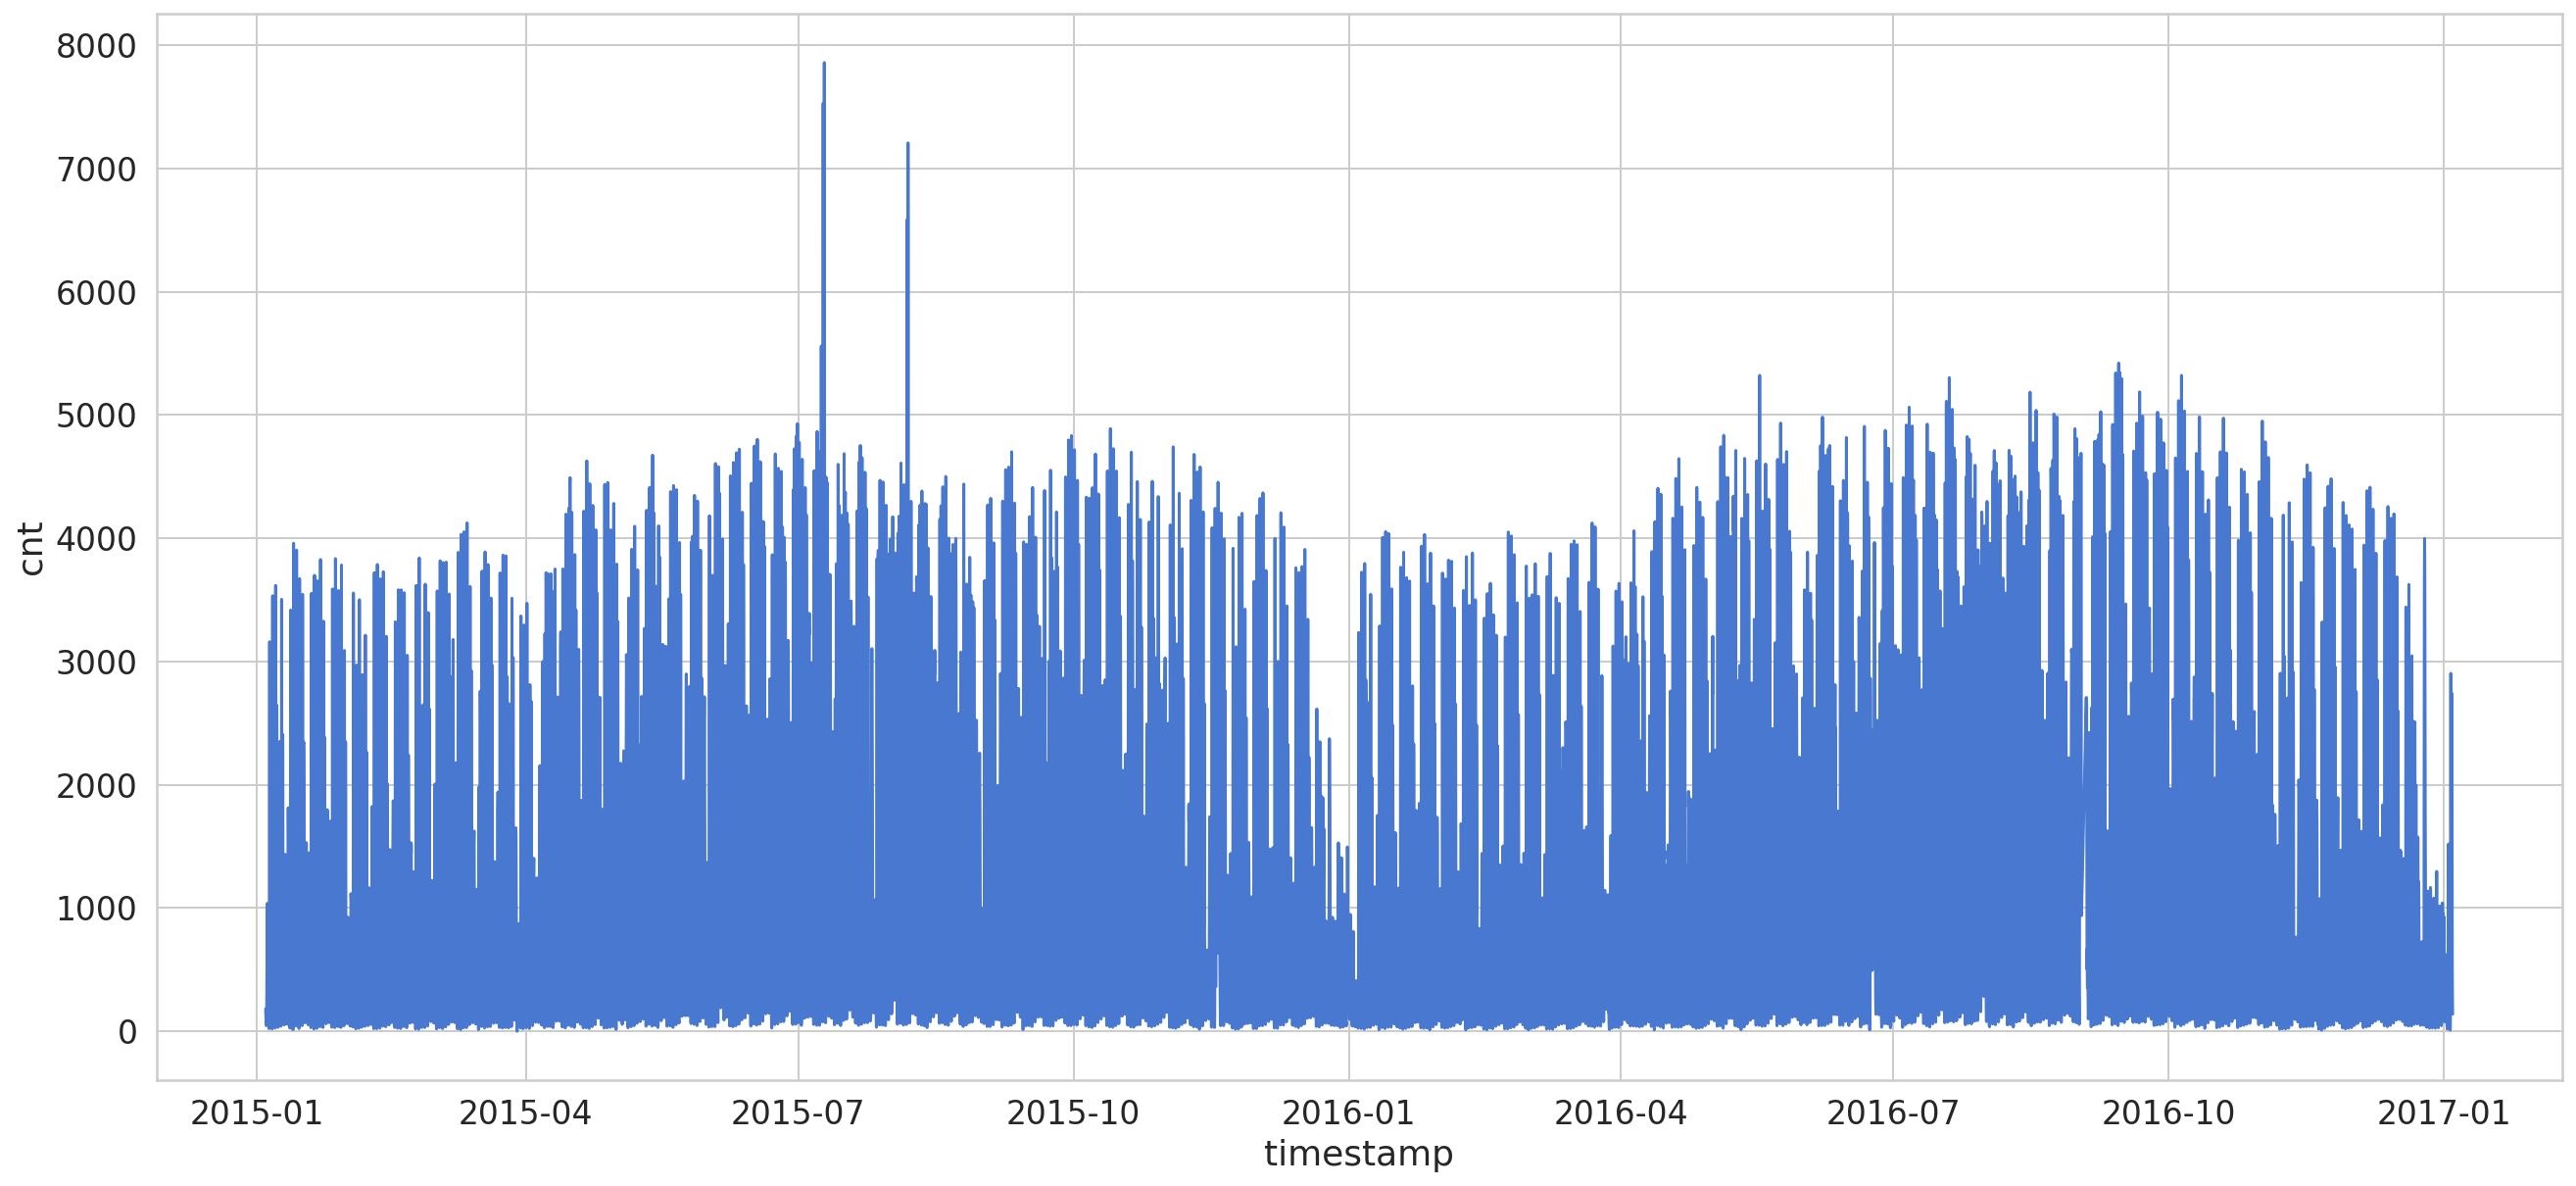

In [9]:
sns.lineplot(x = london_df.index, y = 'cnt', data = london_df)

<h1> Exploration

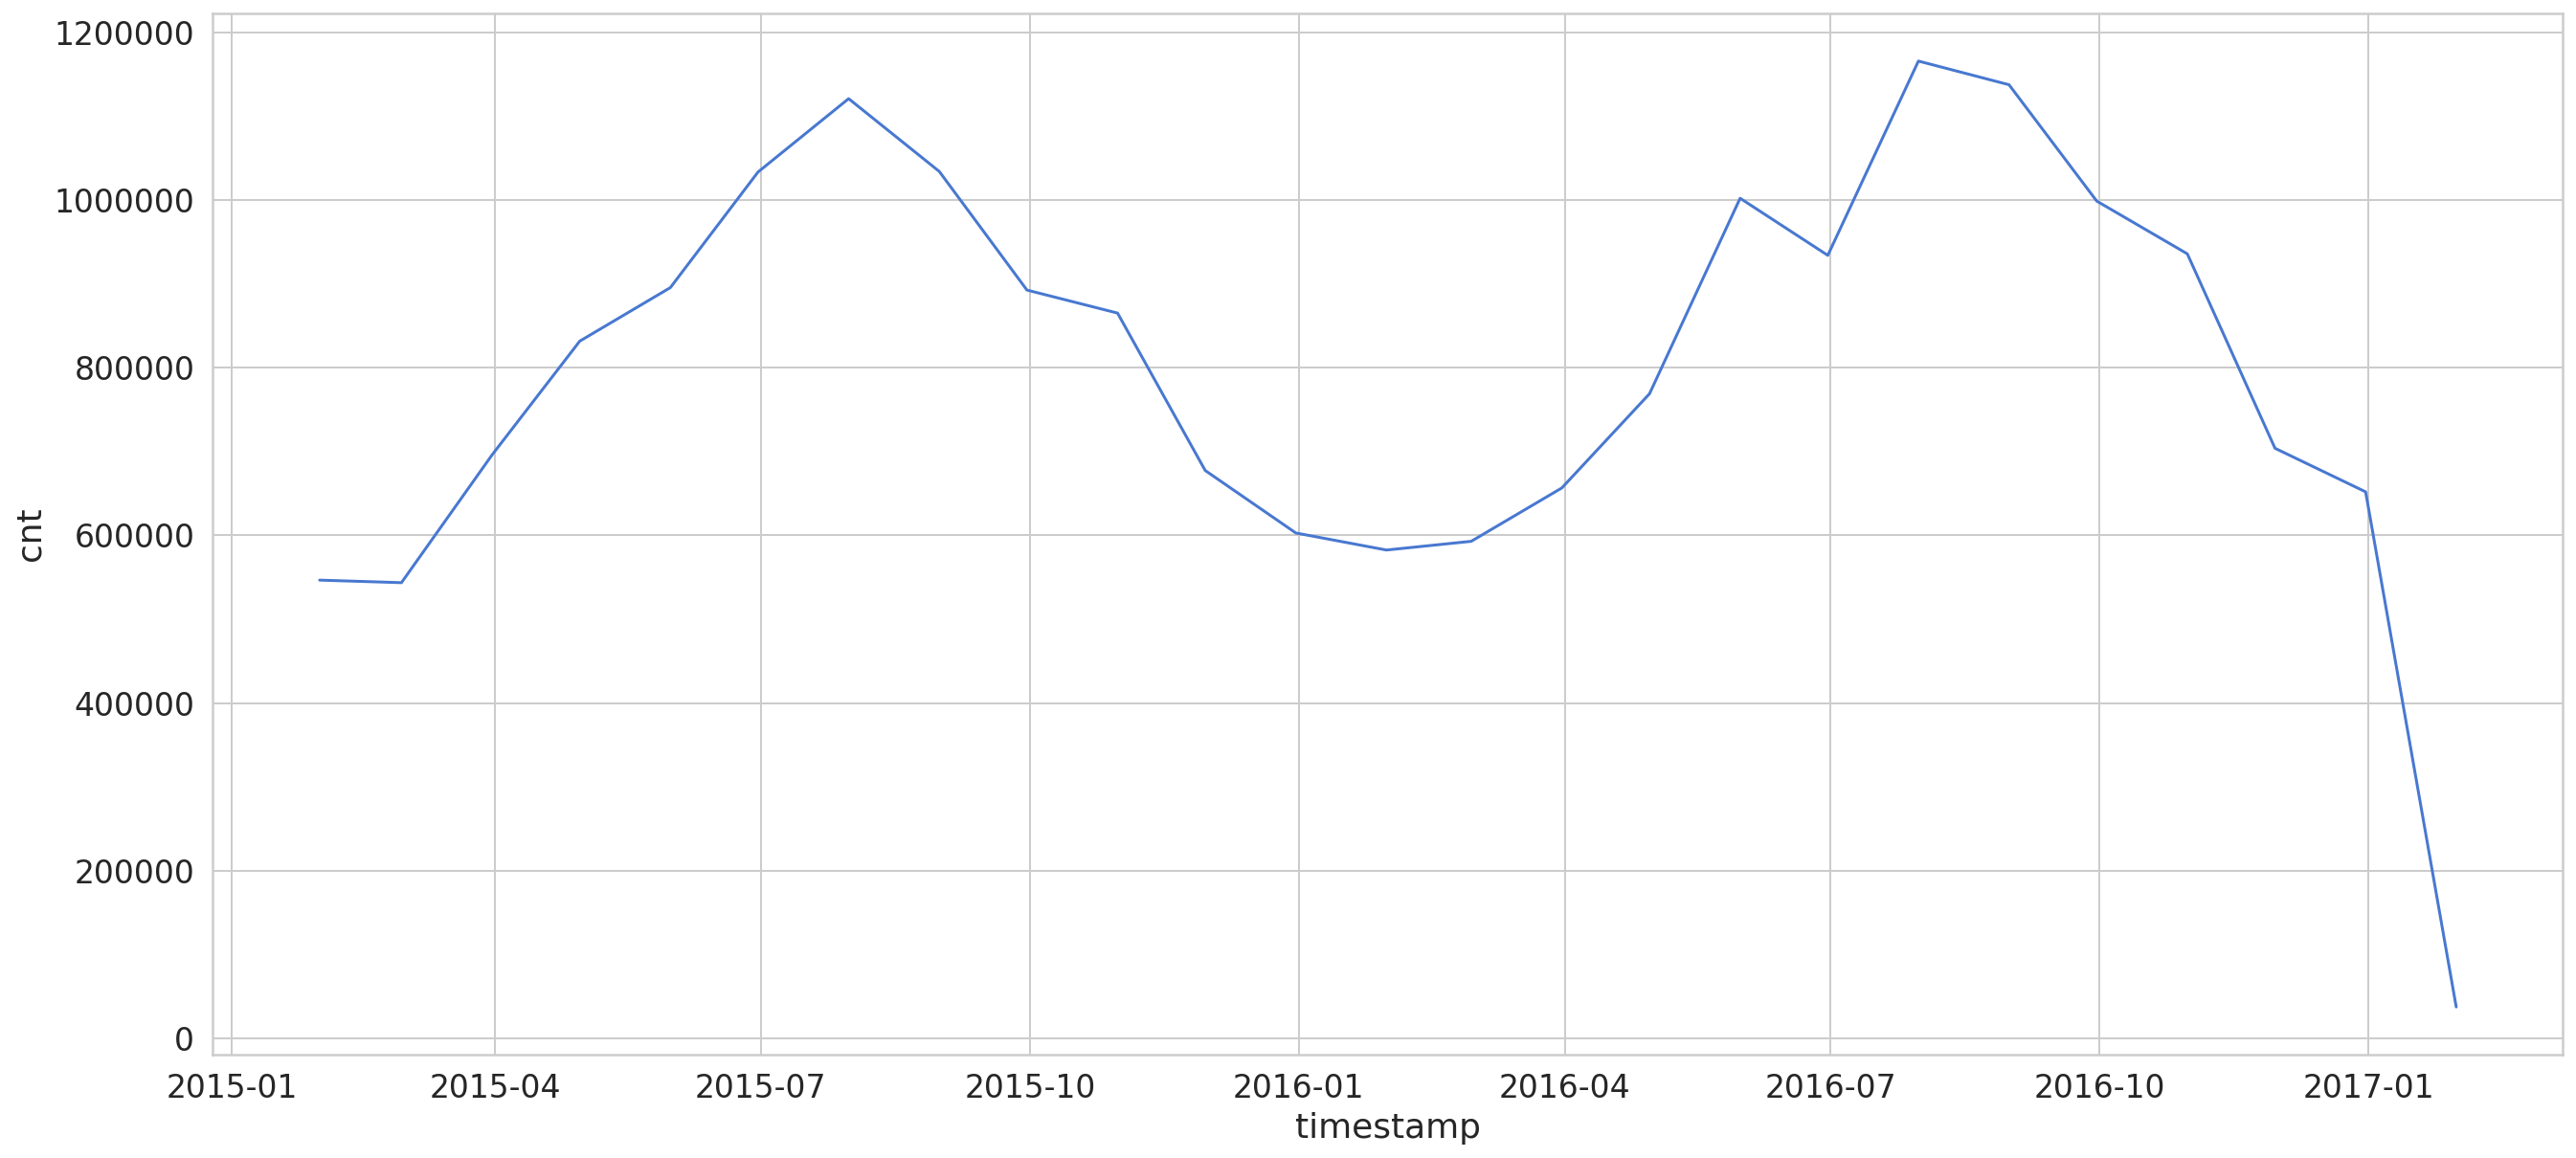

In [10]:
lond_by_month = london_df.resample('M').sum()
sns.lineplot(x = lond_by_month.index, y = 'cnt', data = lond_by_month)

Our data seems to have a strong seasonality component. Summer months are good for business.

How about the bike shares by the hour:

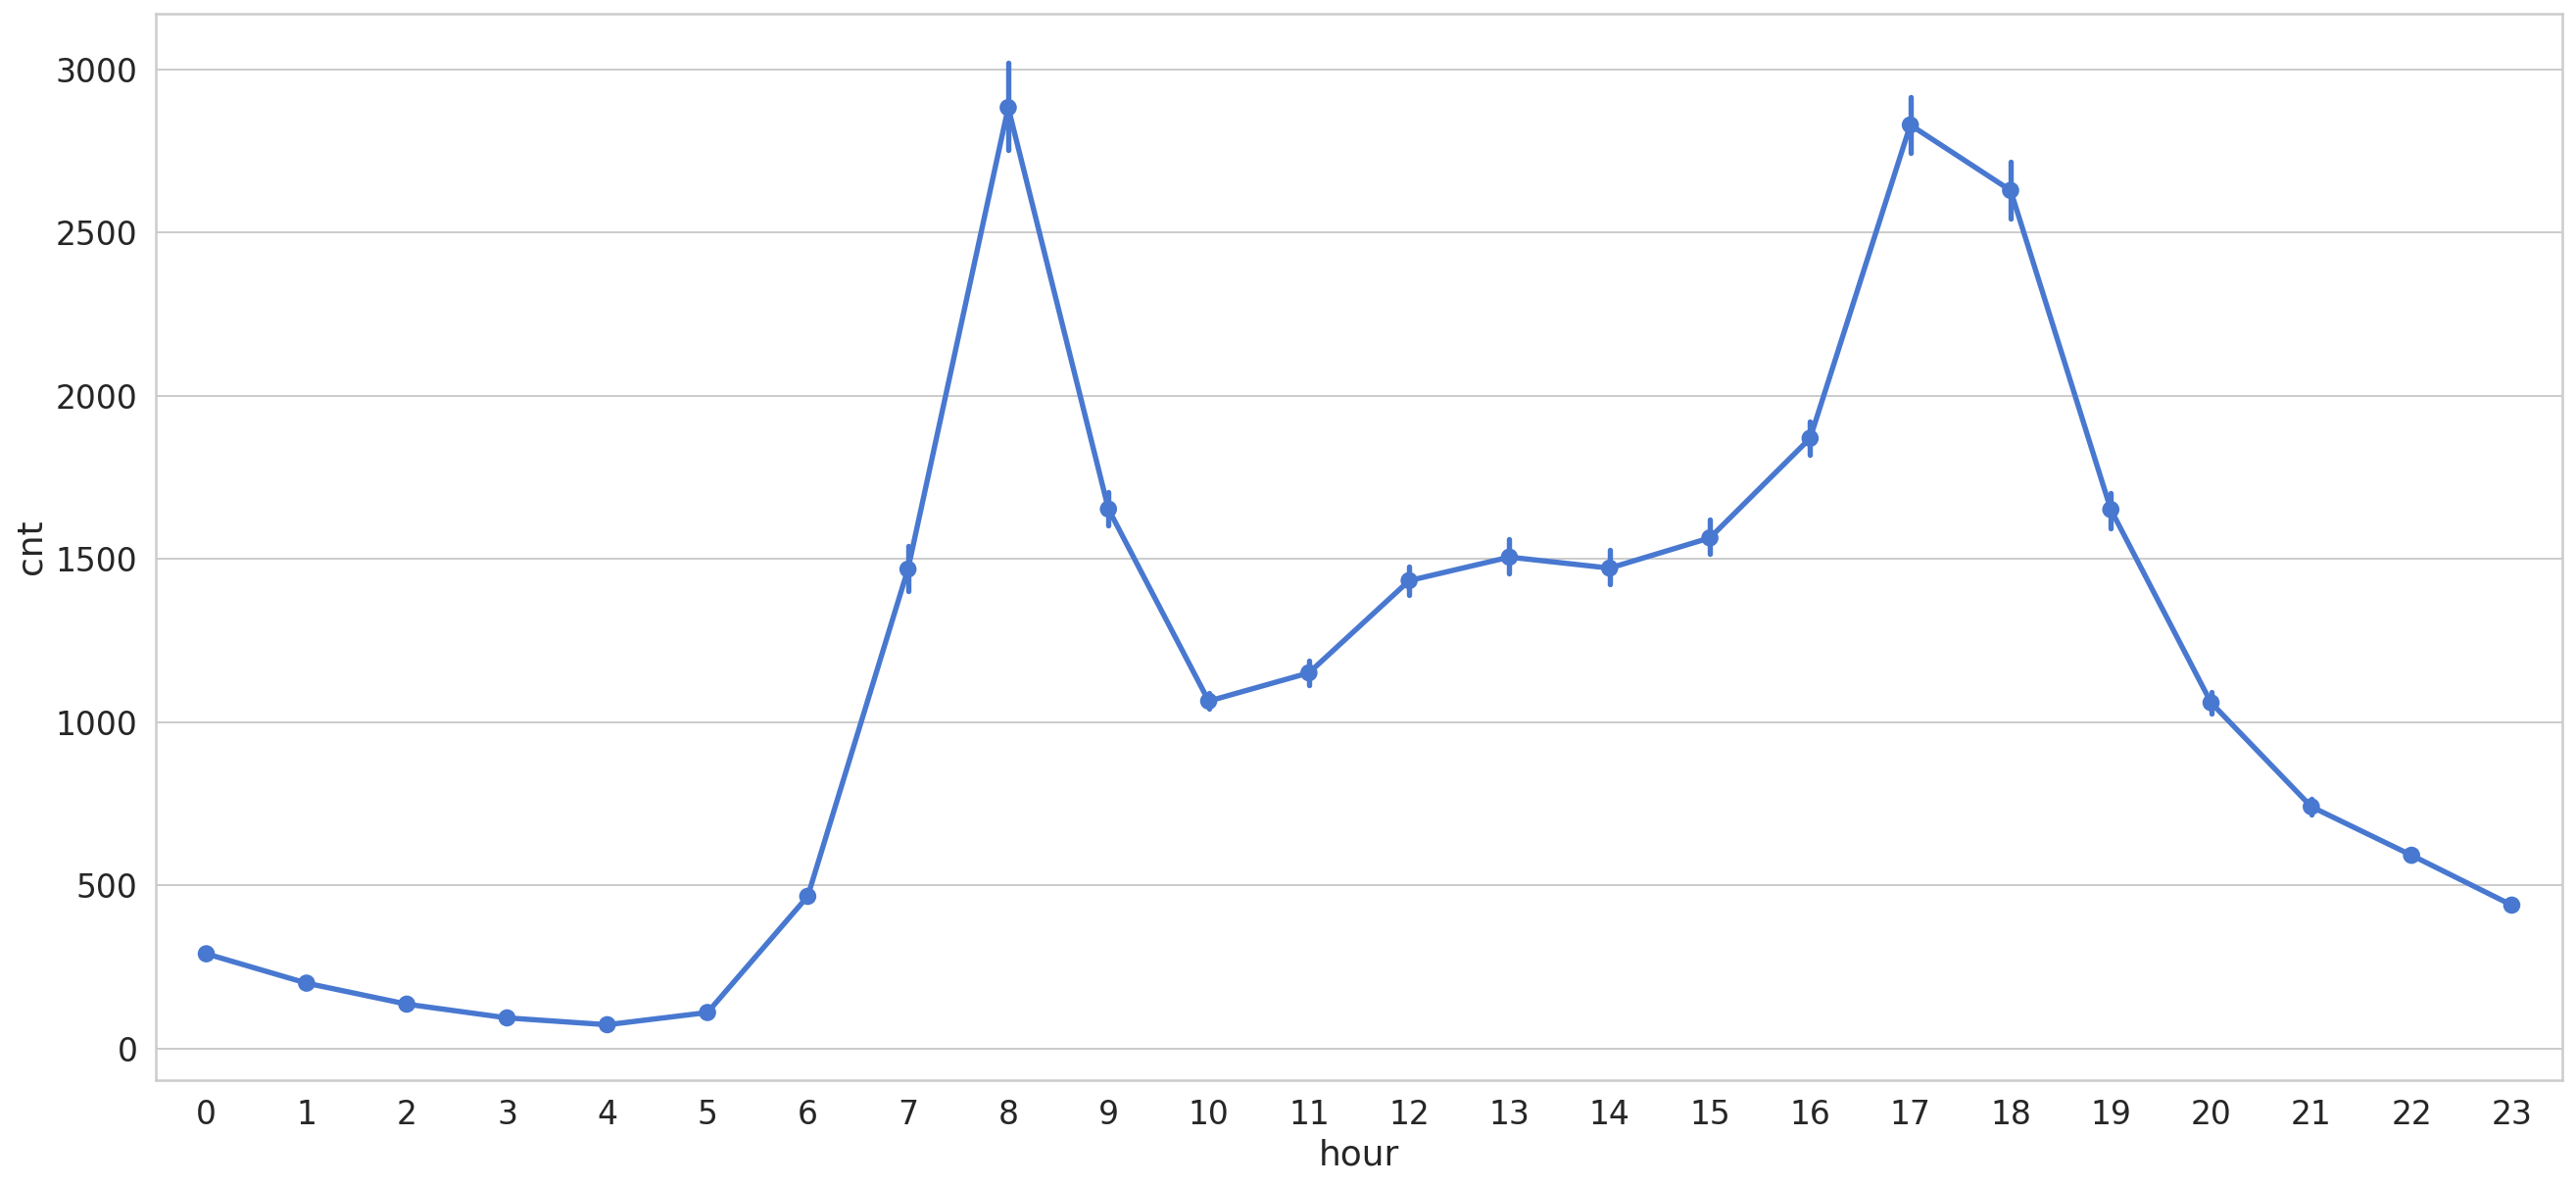

In [11]:
sns.pointplot(x = 'hour', y = 'cnt', data = london_df)

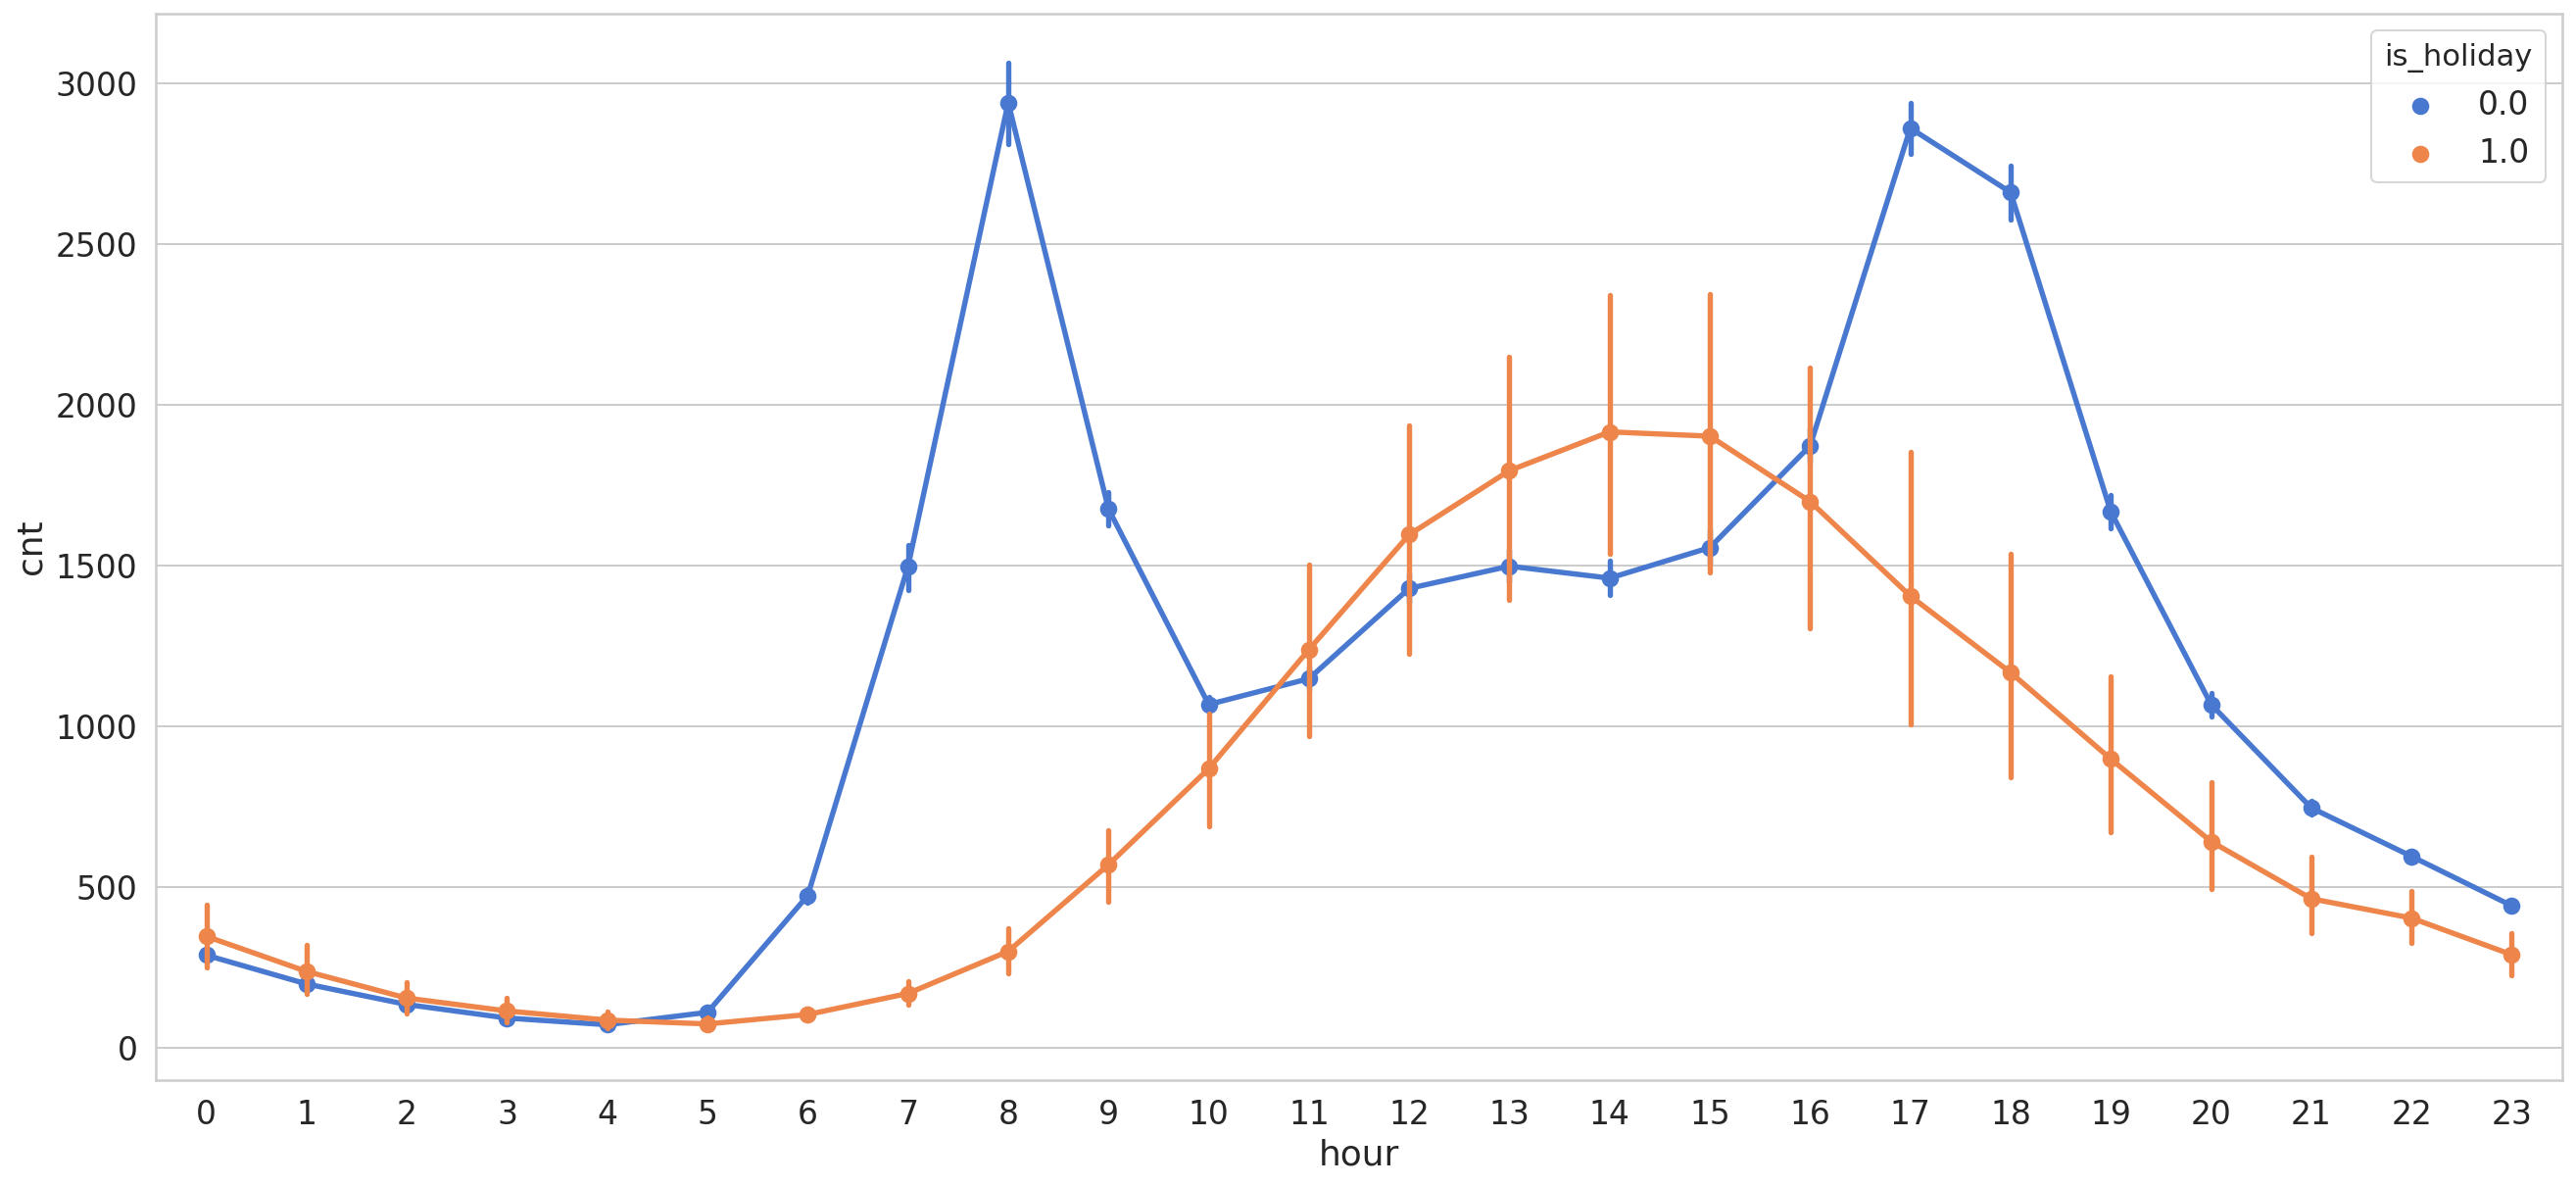

In [12]:
sns.pointplot(x = 'hour', y = 'cnt', data = london_df, hue= 'is_holiday')

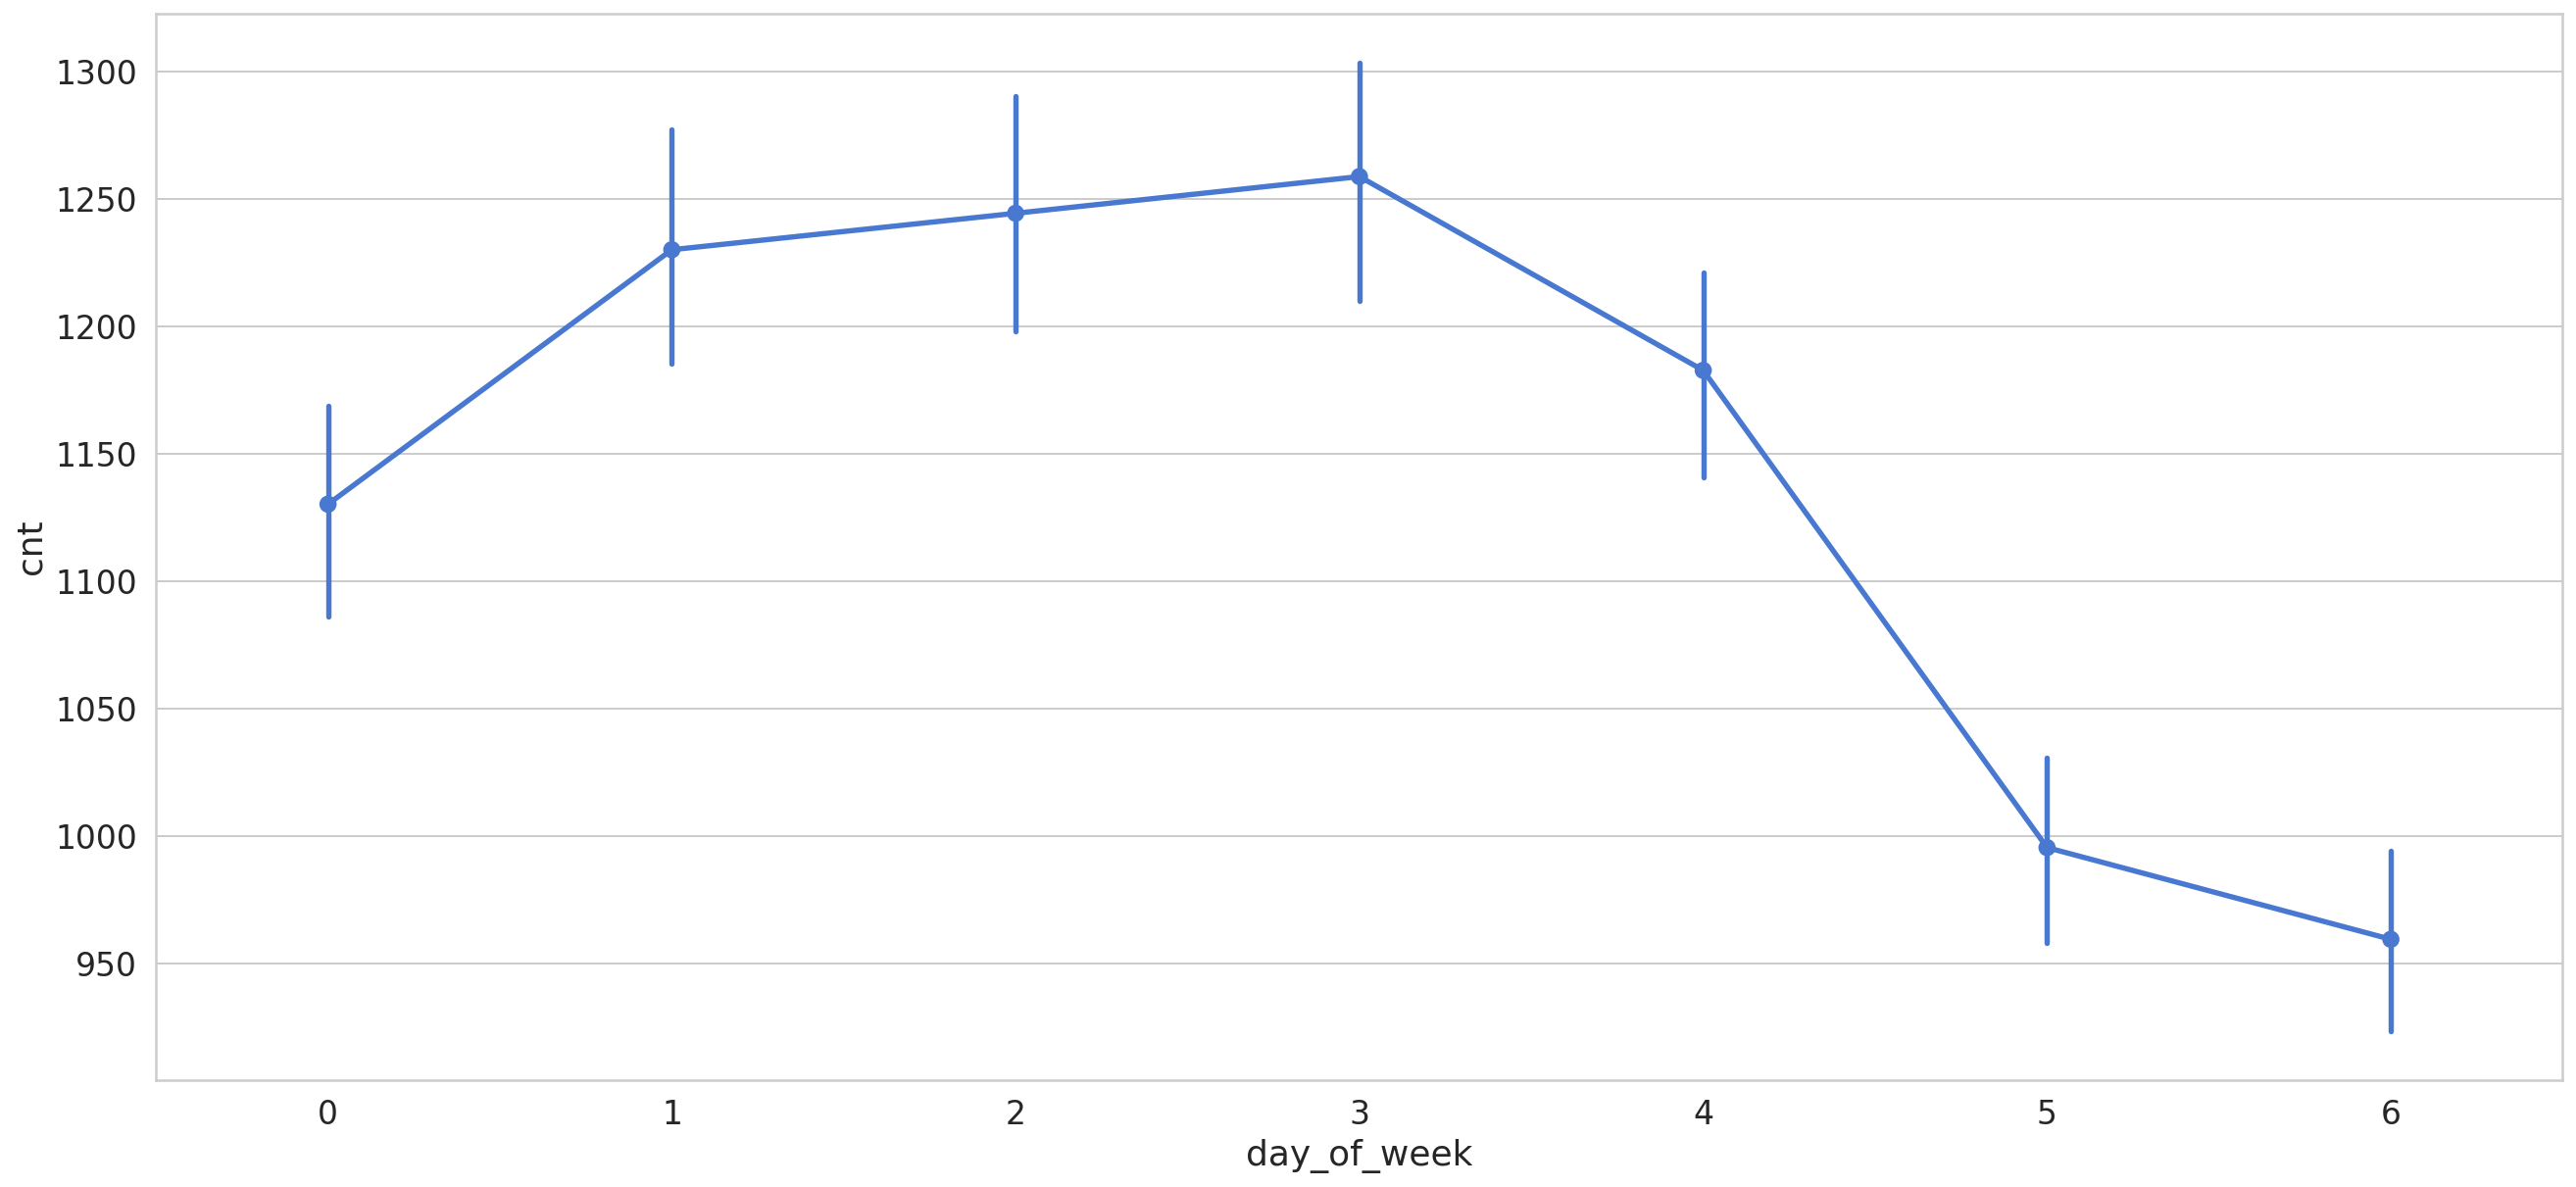

In [13]:
sns.pointplot(x = 'day_of_week', y = 'cnt', data = london_df)

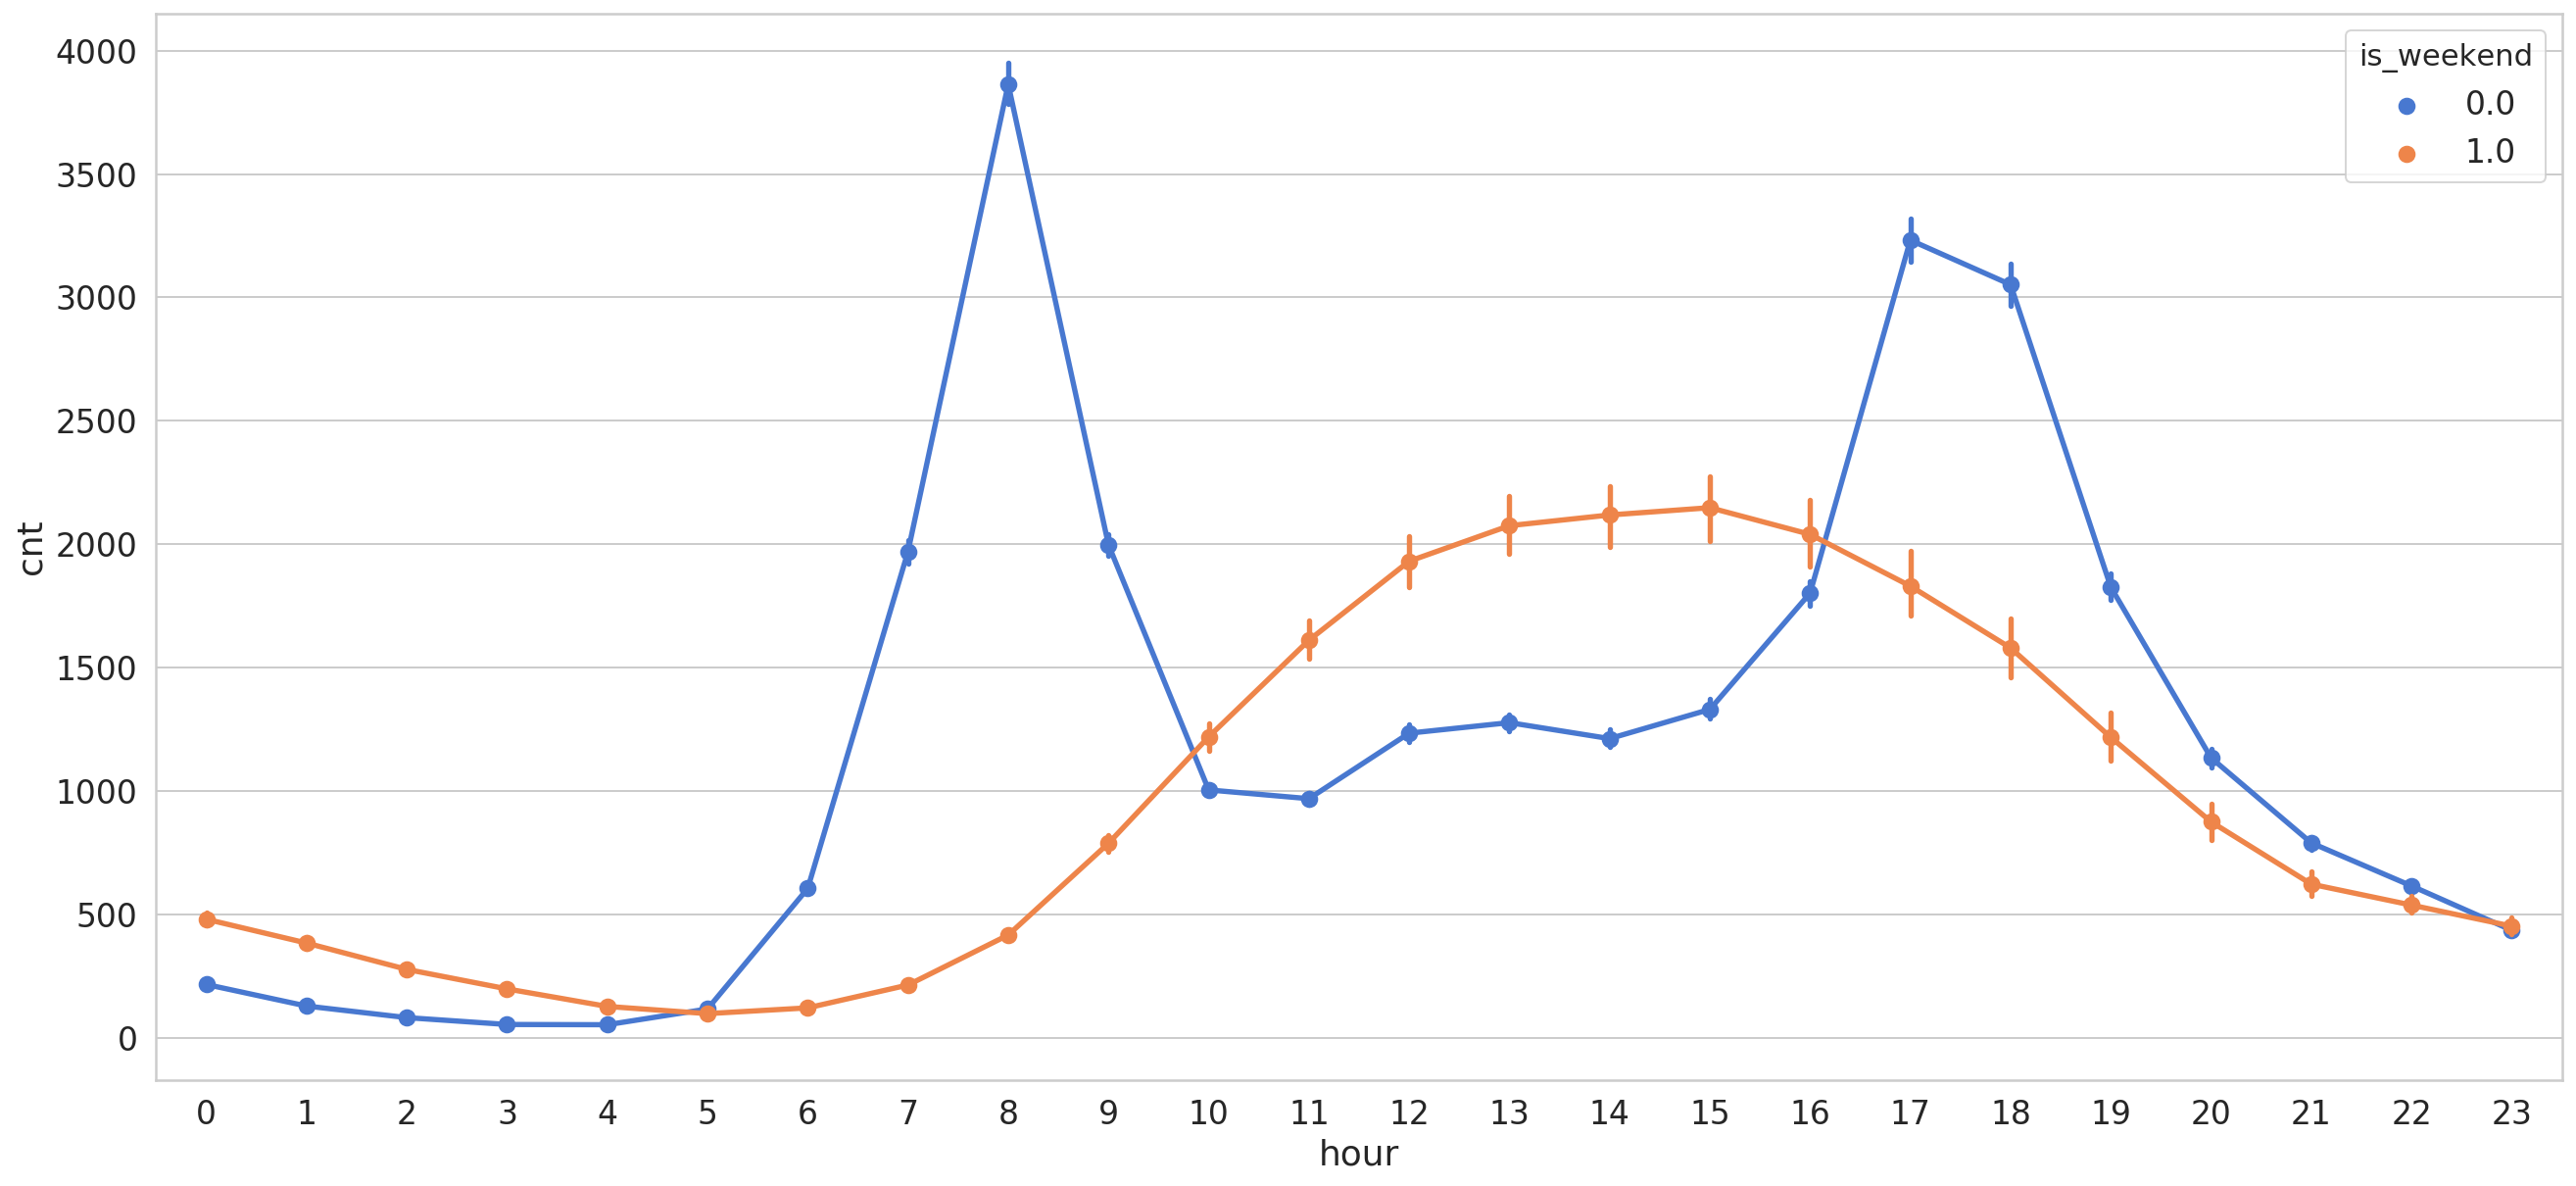

In [14]:
sns.pointplot(x = 'hour', y = 'cnt', data = london_df, hue= 'is_weekend')

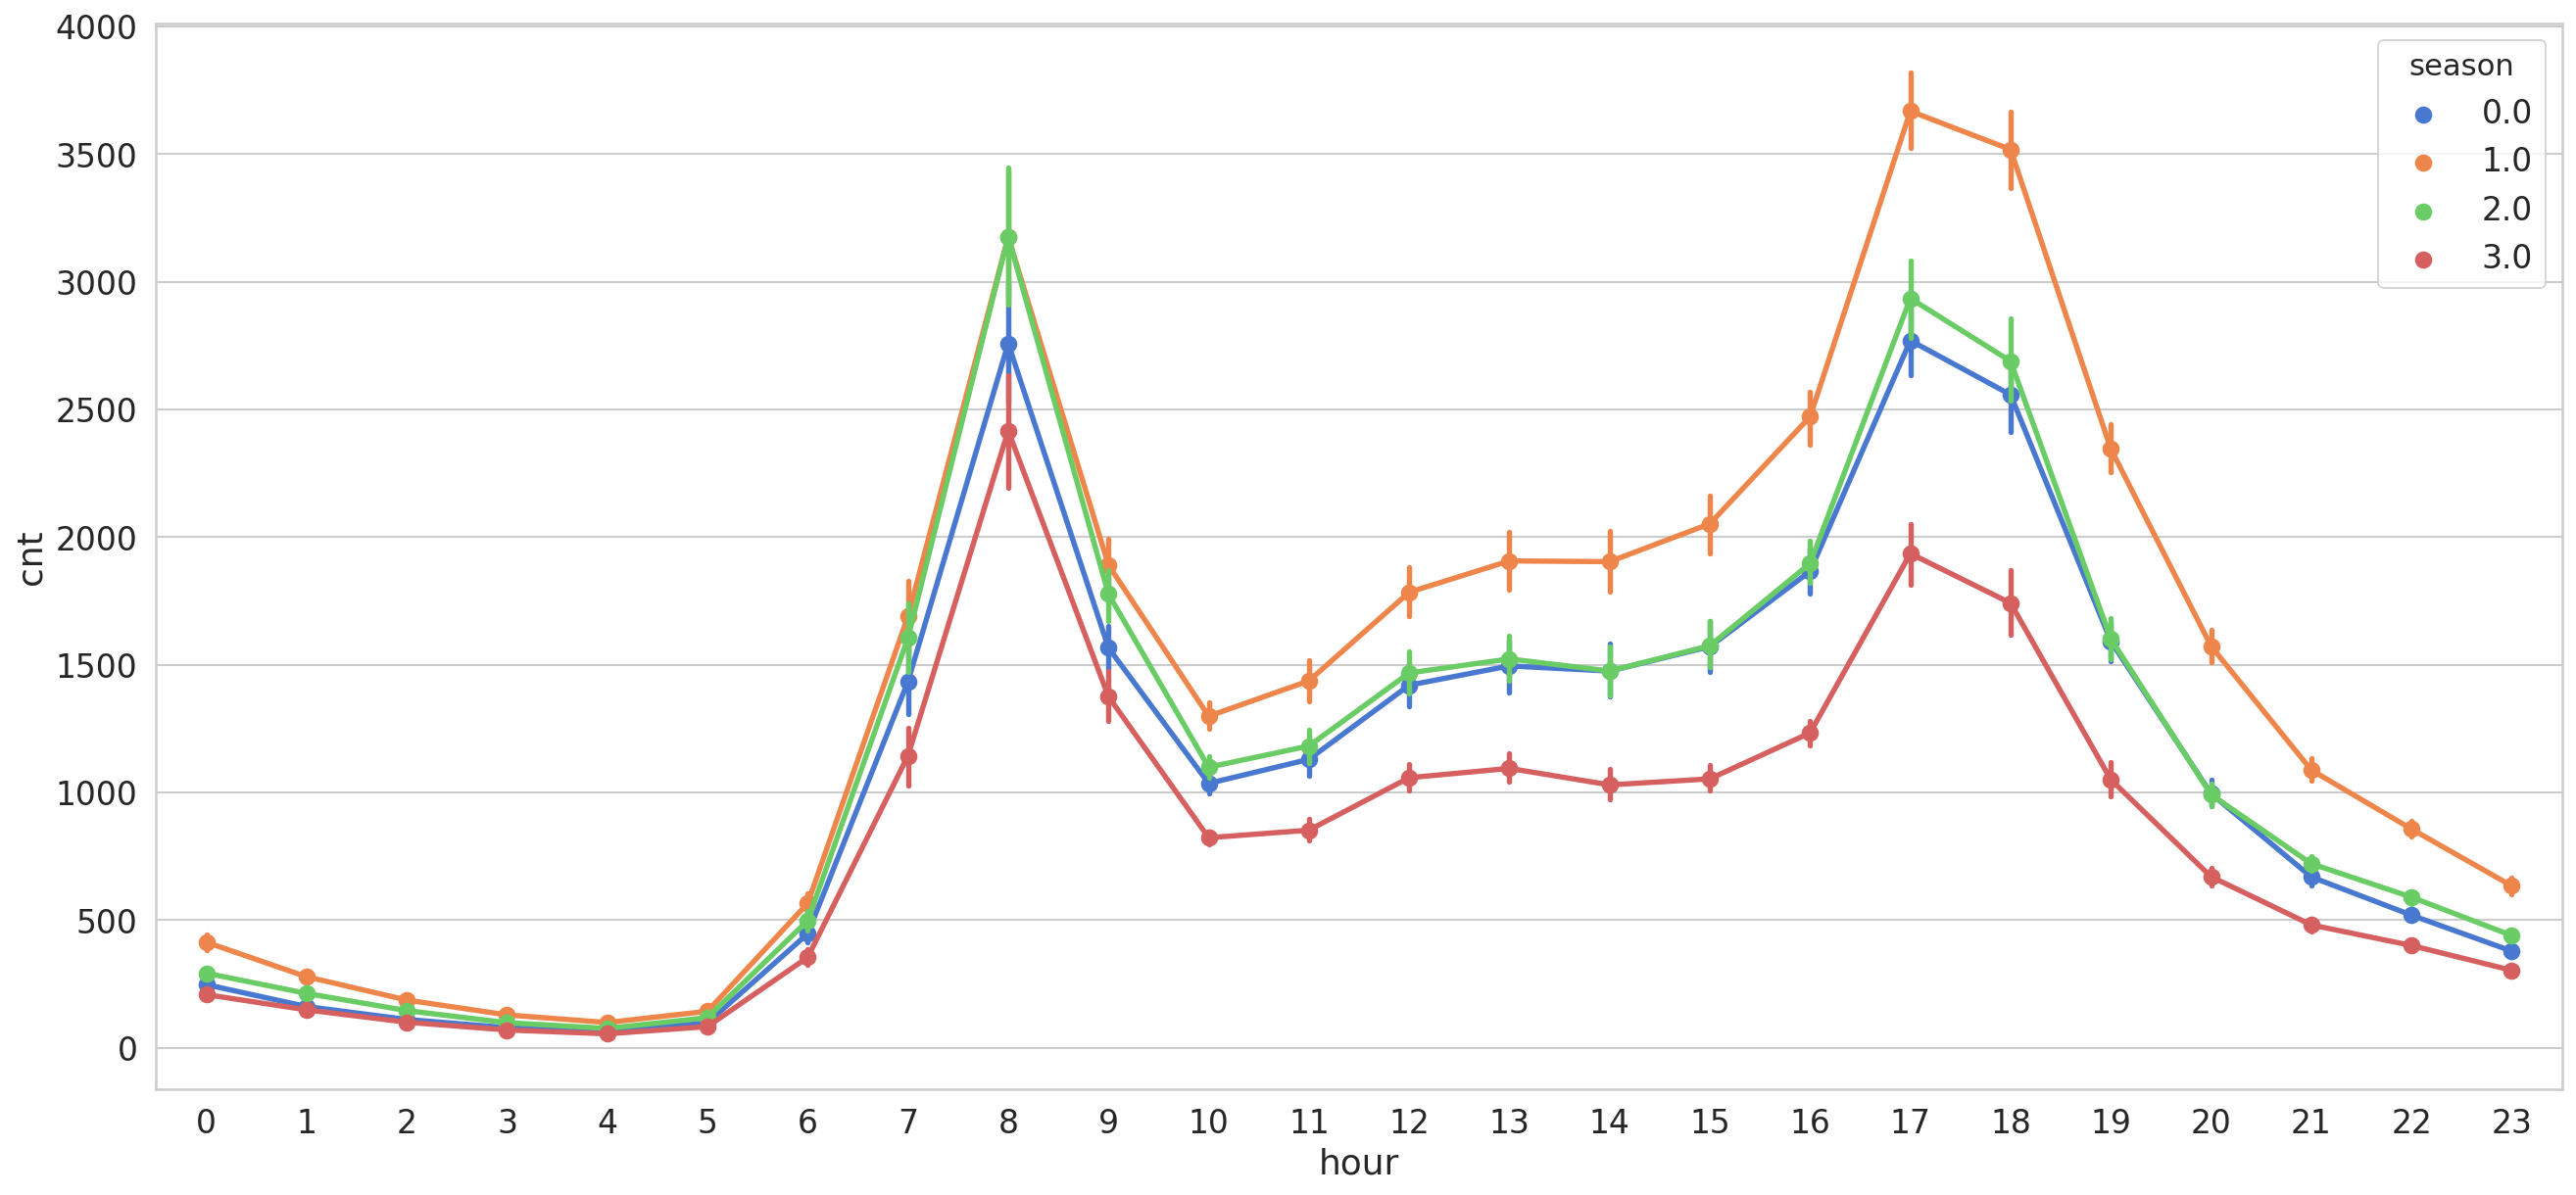

In [15]:
sns.pointplot(x = 'hour', y = 'cnt', data = london_df, hue= 'season')

The hours with most bike shares differ significantly based on a weekend or not days. Workdays contain two large spikes during the morning and late afternoon hours (people pretend to work in between). On weekends early to late afternoon hours seem to be the busiest.

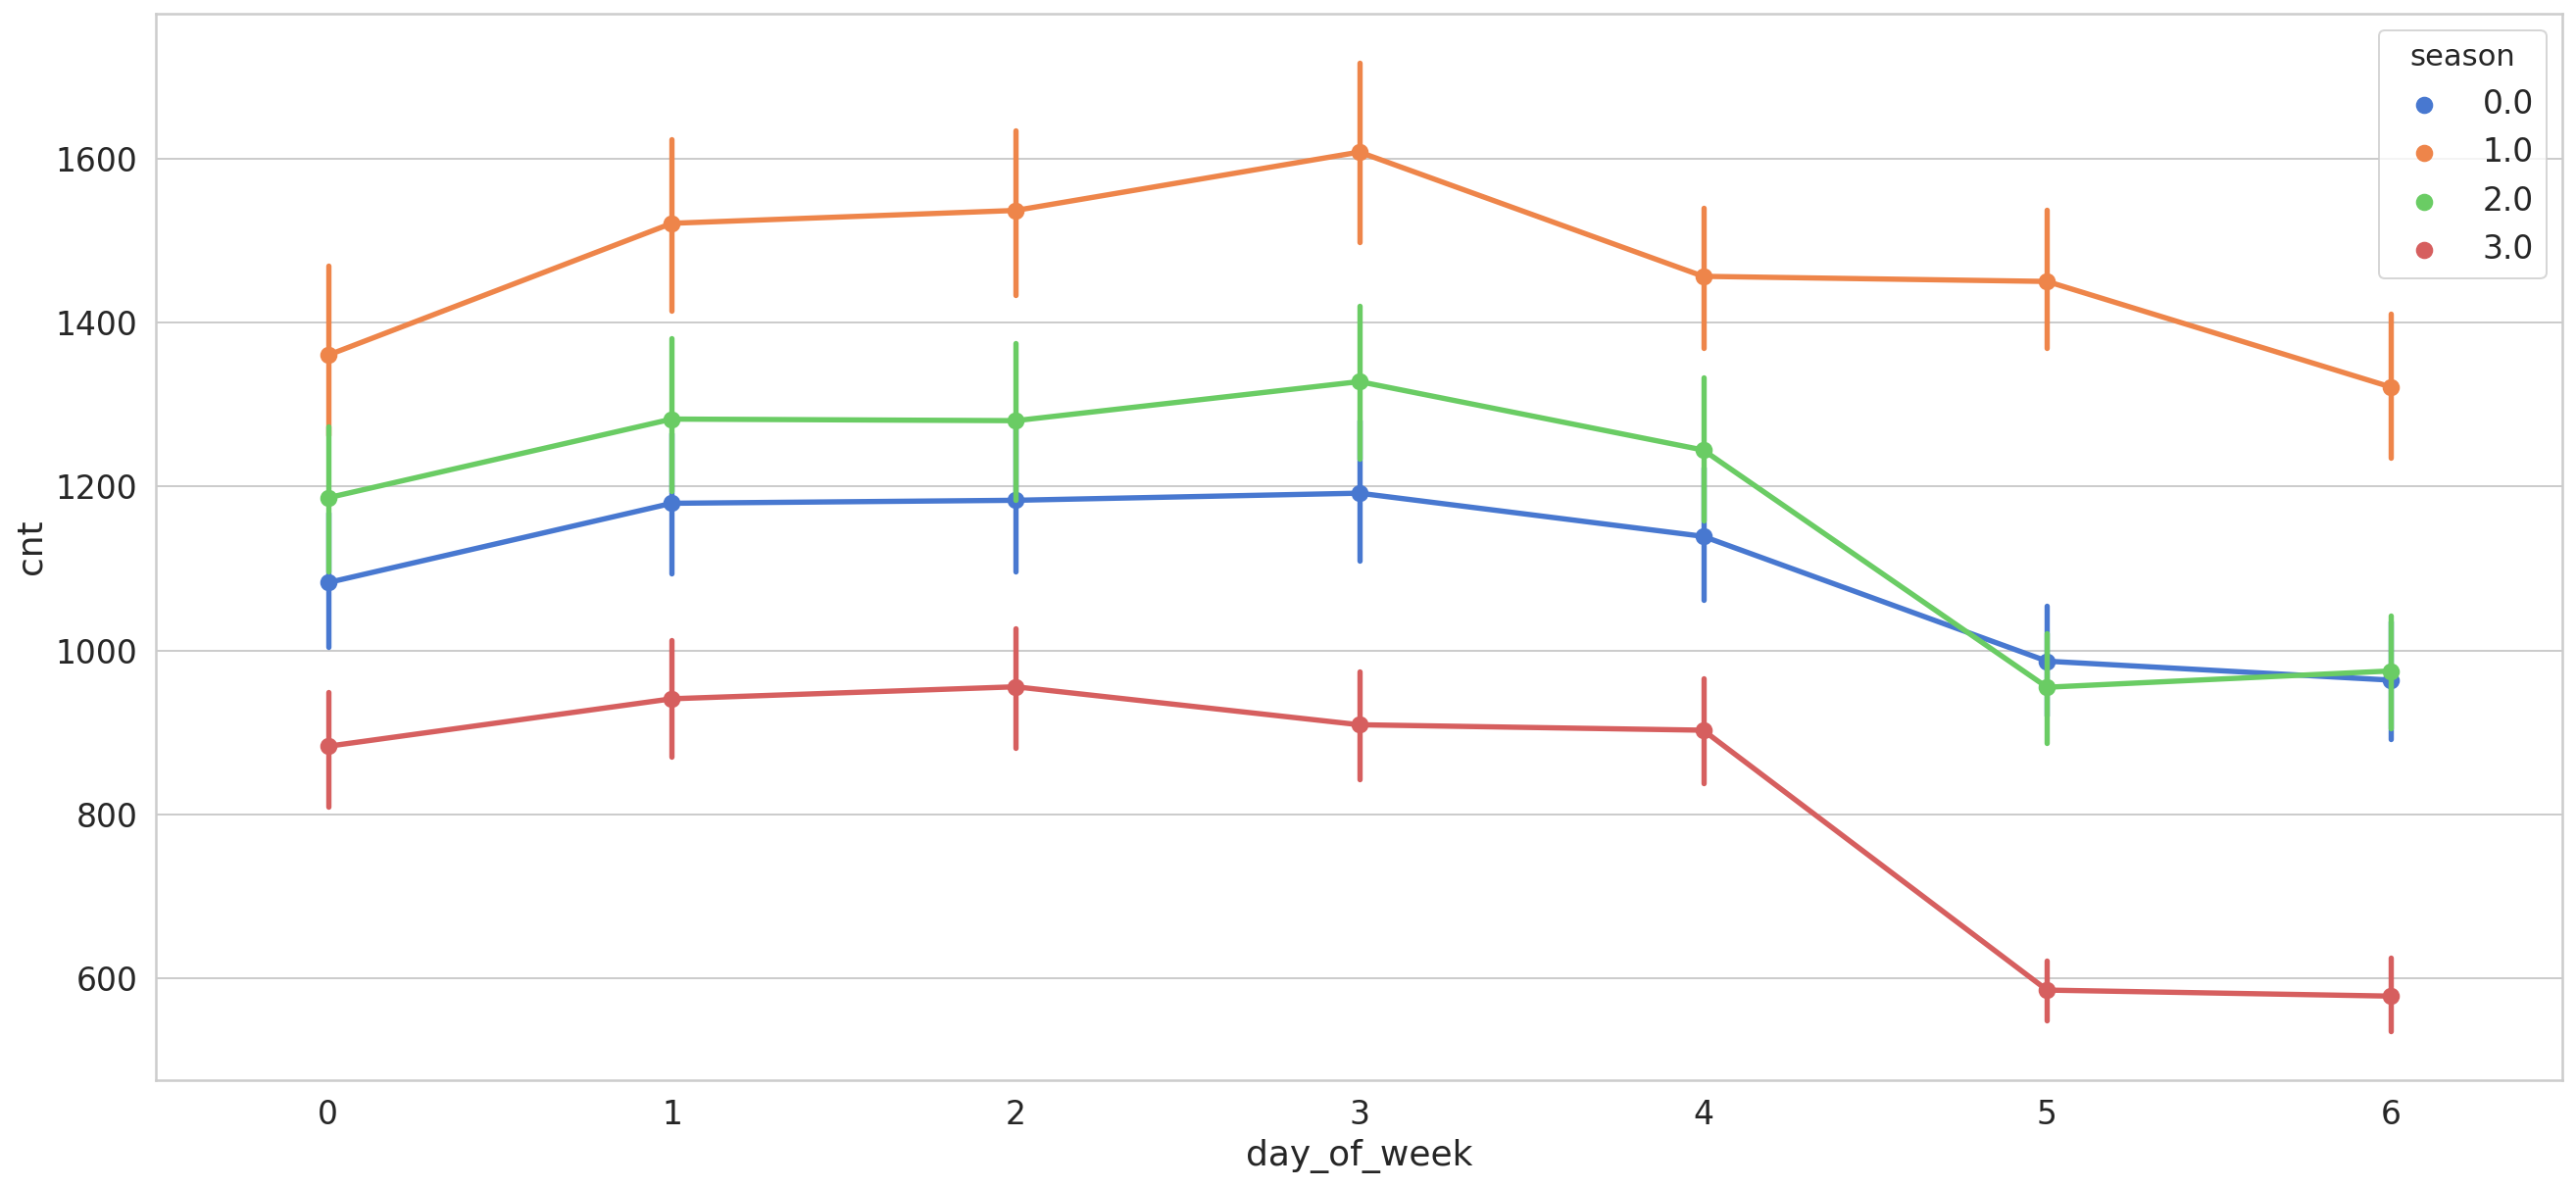

In [16]:
sns.pointplot(x = 'day_of_week', y = 'cnt', data = london_df, hue= 'season')

Looking at the data by day of the week shows a much higher count on the number of bike shares.

Our little feature engineering efforts seem to be paying off. The new features separate the data very well.

<h1> Preprocessing

In [0]:
train_size = int(len(london_df) * 0.9)
test_size = (len(london_df) - train_size)

In [18]:
train, test = london_df.iloc[0:train_size], london_df.iloc[train_size:len(london_df)]
print(train.shape, test.shape)

(15672, 13) (1742, 13)


We’ll also scale the number of bike shares too:

In [19]:
from sklearn.preprocessing import RobustScaler

columns = ['t1', 't2', 'hum', 'wind_speed']
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, columns] = f_transformer.transform(train[columns].to_numpy())
test.loc[:, columns] = f_transformer.transform(test[columns].to_numpy())

train['cnt'] = cnt_transformer.transform(train[['cnt']])

test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

To prepare the sequences, we’re going to reuse the same create_dataset() function:

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Each sequence is going to contain 24 data points from the history:

In [21]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


In [22]:
print(X_test.shape, y_test.shape)

(1718, 24, 13) (1718,)


In [27]:
X_test[0][0]

array([-0.37052342, -0.625     , -0.57142857,  0.675     , -0.81818182,
        2.        ,  0.        ,  1.        ,  2.        ,  8.        ,
       23.        ,  6.        , 10.        ])

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras

<h1>Predicting Demand</h1>

Let’s start with a simple model and see how it goes. One layer of Bidirectional LSTM with a Dropout layer:

In [0]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

Remember to NOT shuffle the data when training

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 14083 samples, validate on 1565 samples
Epoch 1/30
14083/14083 [==============================] - 10s 730us/sample - loss: 0.3290 - val_loss: 0.2057
Epoch 2/30
14083/14083 [==============================] - 3s 194us/sample - loss: 0.1169 - val_loss: 0.0768
Epoch 3/30
14083/14083 [==============================] - 3s 194us/sample - loss: 0.0657 - val_loss: 0.0555
Epoch 4/30
14083/14083 [==============================] - 3s 203us/sample - loss: 0.0453 - val_loss: 0.0434
Epoch 5/30
14083/14083 [==============================] - 3s 193us/sample - loss: 0.0385 - val_loss: 0.0405
Epoch 6/30
14083/14083 [==============================] - 3s 192us/sample - loss: 0.0333 - val_loss: 0.0323
Epoch 7/30
14083/14083 [==============================] - 3s 192us/sample - loss: 0.0296 - val_loss: 0.0345
Epoch 8/30
14083/14083 [==============================] - 3s 196us/sample - loss: 0.0267 - val_loss: 0.0317
Epoch 9/30
14083/14083 [==============================] - 3s 194us/sample - loss: 0.02

<h1>Evaluation</h1>

Here’s what we have after training our model for 30 epochs:

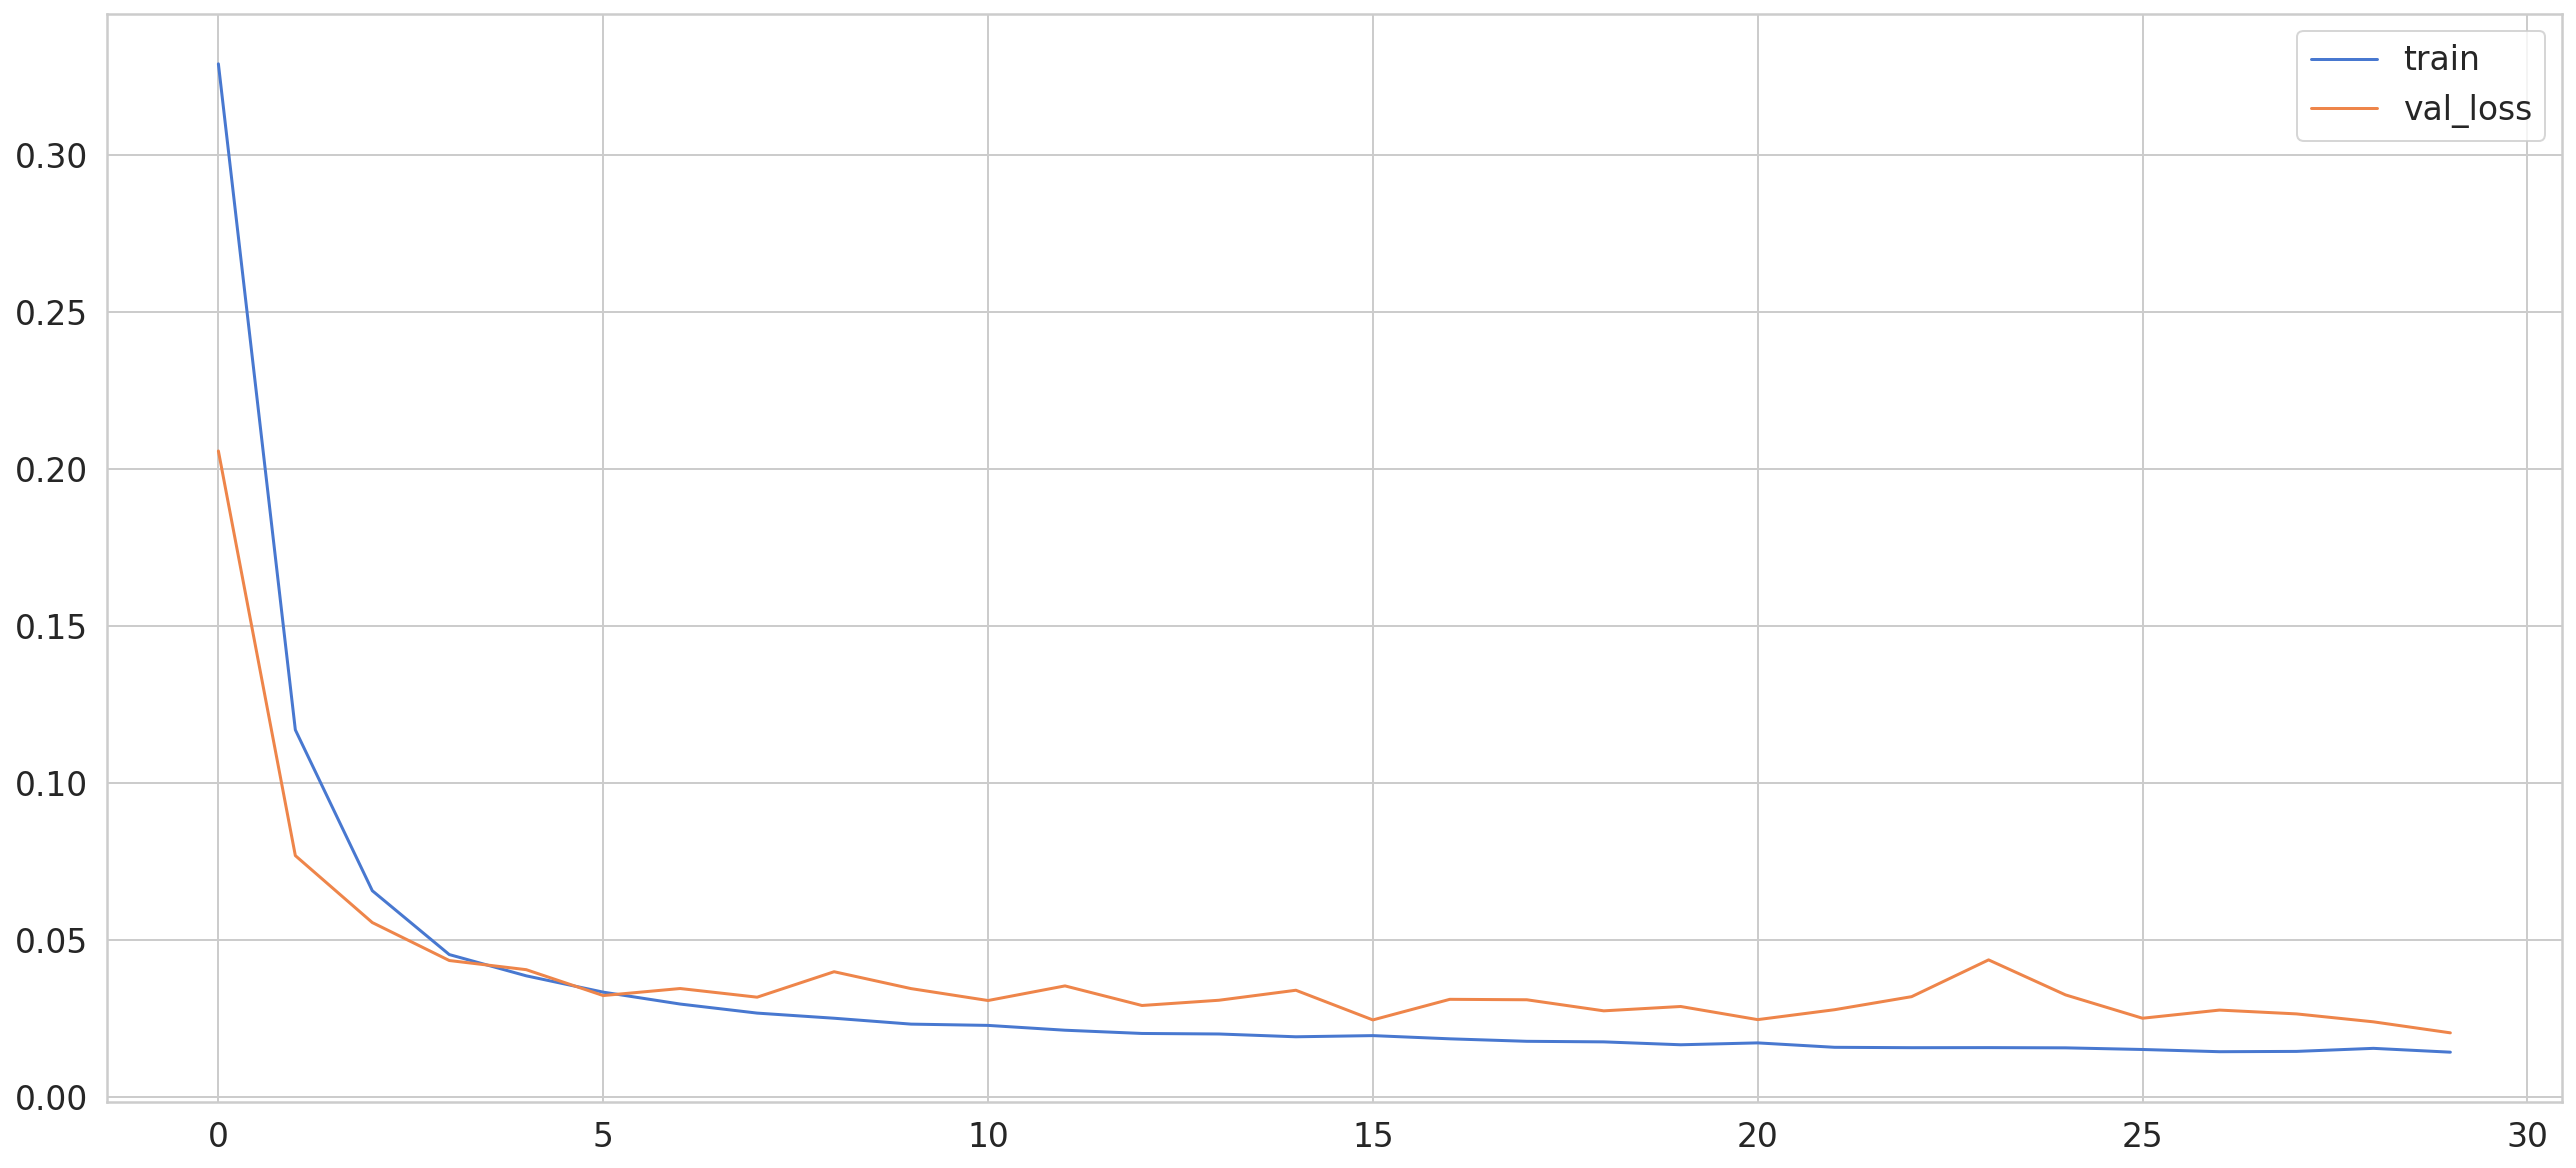

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(-1,1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

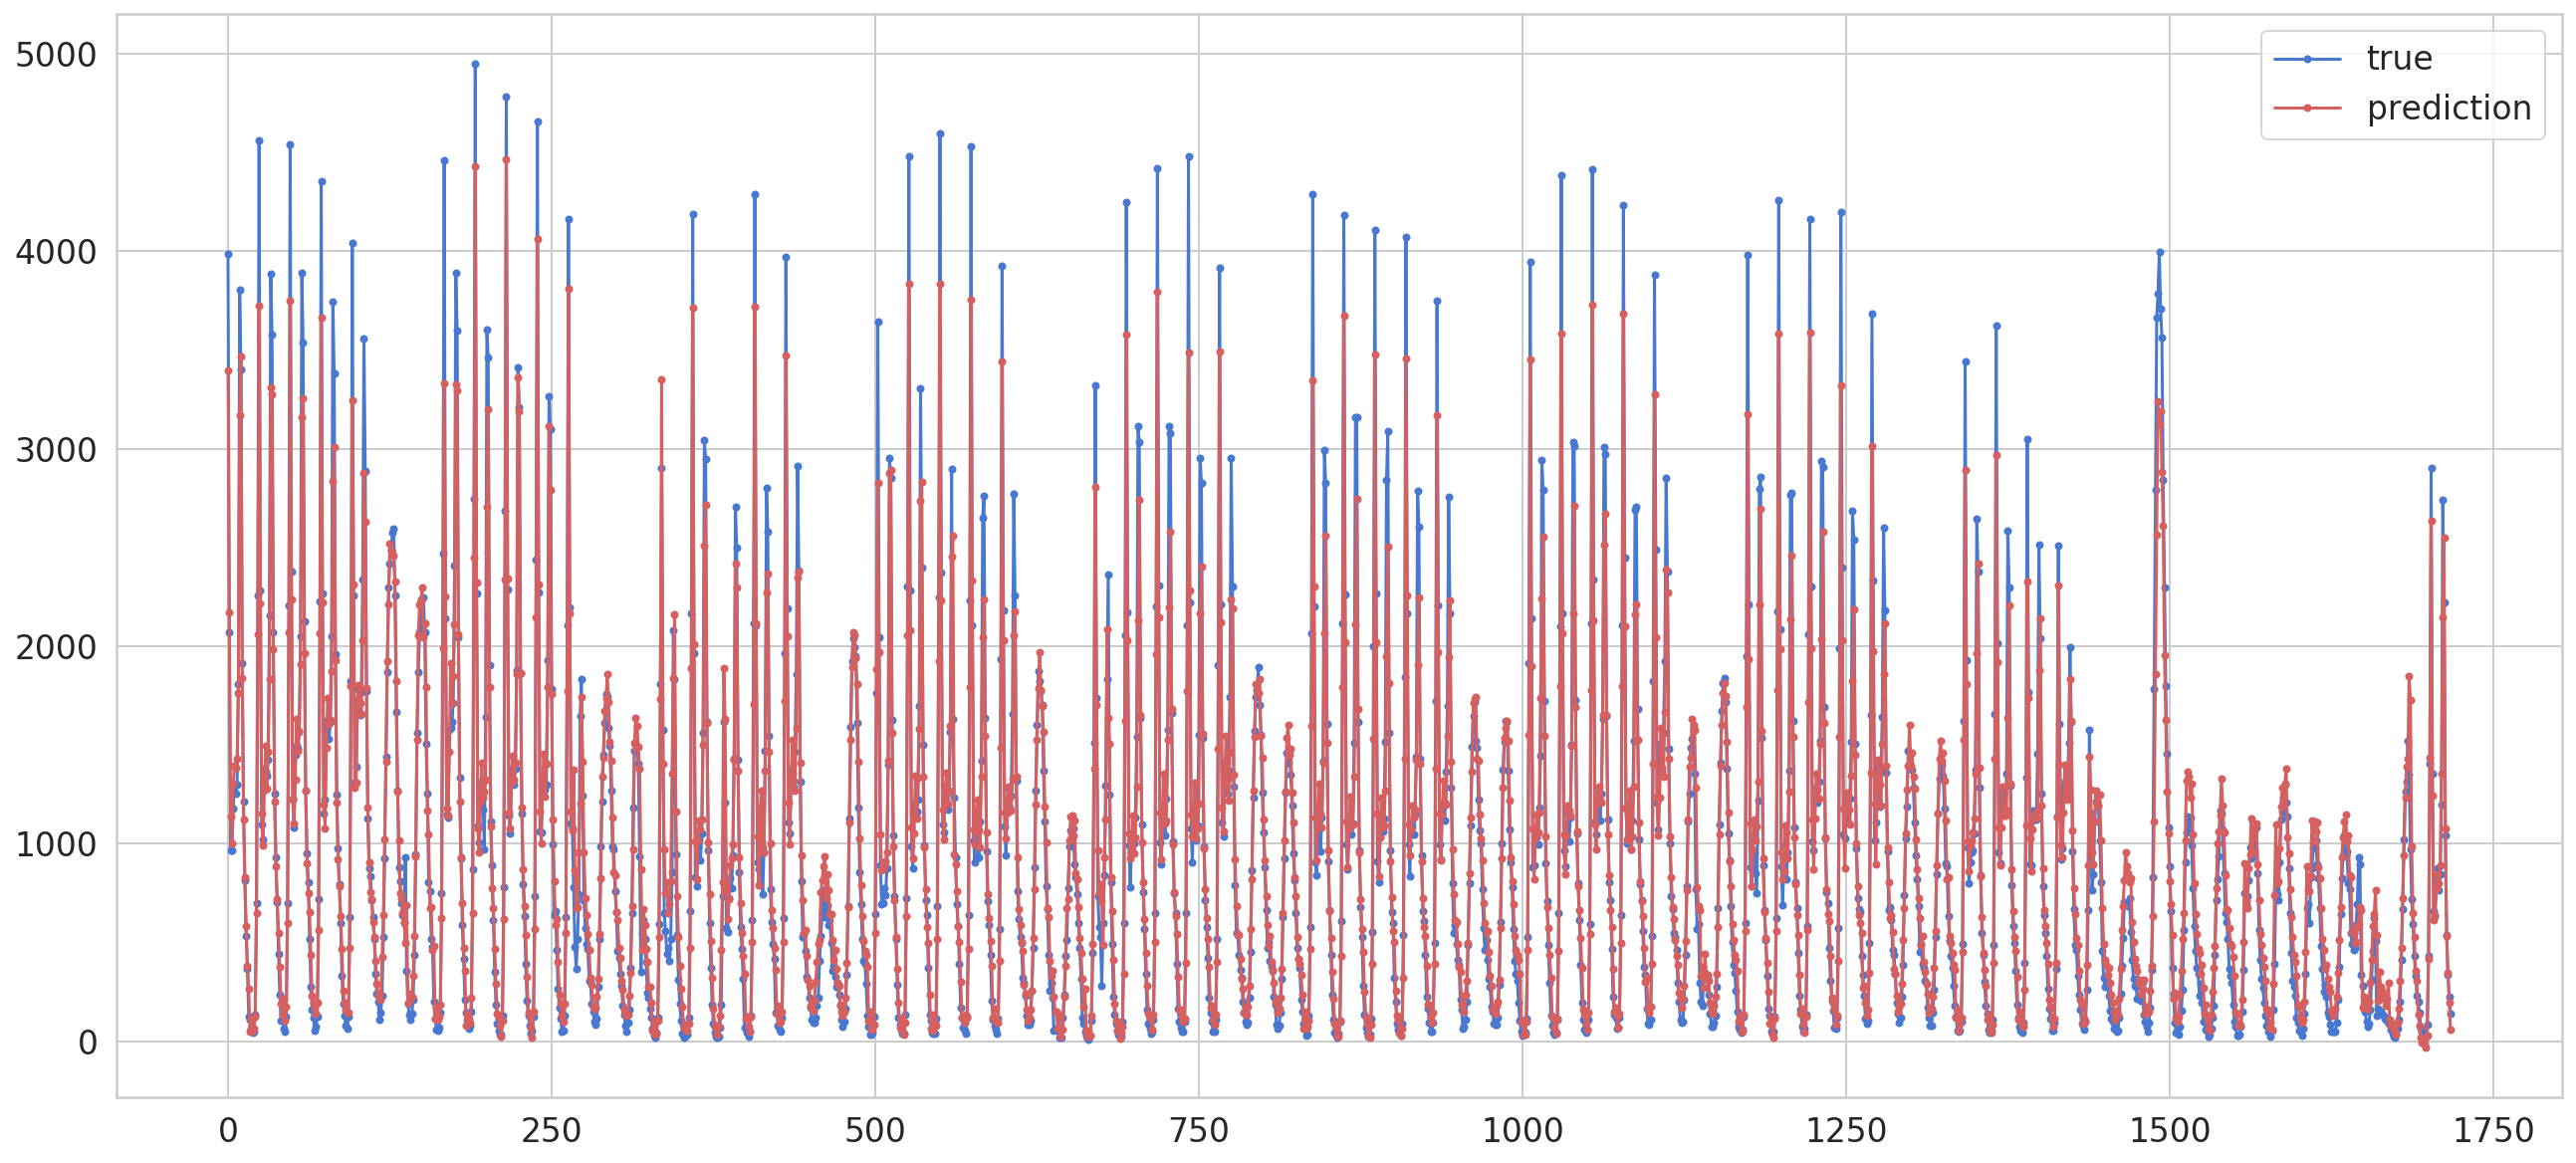

In [41]:
plt.plot(y_test_inv.flatten(), marker = '.', label = 'true')
plt.plot(y_pred_inv.flatten(), 'r', marker = '.', label = 'prediction')
plt.legend()

Note that our model is predicting only one point in the future. That being said, it is doing very well. Although our model can’t really capture the extreme values it does a good job of predicting (understanding) the general pattern.

<h1>Conclusion</h1>

We just took a real dataset, preprocessed it, and used it to predict bike-sharing demand. We have used a Bidirectional LSTM model to train it on subsequences from the original dataset. You even got some very good results.